# Learning to square the input

This demo shows you how to construct a network
containing an ensemble which learns how to decode the square of its value.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import nengo

## Step 1: Create the Model

This network consists of an ensemble `A` which represents the input,
an ensemble `A_squared` which learns to represent the square,
and an ensemble `error` which represents the error
between `A_squared` and the actual square.

In [2]:
model = nengo.Network()
with model:
    # Create the ensemble to represent the input, the input squared (learned),
    # and the error
    A = nengo.Ensemble(100, dimensions=1)
    A_squared = nengo.Ensemble(100, dimensions=1)
    error = nengo.Ensemble(100, dimensions=1)

    # Connect A and A_squared with a communication channel
    conn = nengo.Connection(A, A_squared)

    # Apply the PES learning rule to conn
    conn.learning_rule_type = nengo.PES(learning_rate=3e-4)

    # Provide an error signal to the learning rule
    nengo.Connection(error, conn.learning_rule)

    # Compute the error signal (error = actual - target)
    nengo.Connection(A_squared, error)

    # Subtract the target (this would normally come from some external system)
    nengo.Connection(A, error, function=lambda x: x ** 2, transform=-1)

## Step 2: Provide Input to the Model

A single input signal (a step function)
will be used to drive the neural activity in ensemble A.
An additional node will inhibit the error signal after 15 seconds,
to test the learning at the end.

In [3]:
with model:
    # Create an input node that steps between -1 and 1
    input_node = nengo.Node(output=lambda t: int(6 * t / 5) / 3.0 % 2 - 1)

    # Connect the input node to ensemble A
    nengo.Connection(input_node, A)

    # Shut off learning by inhibiting the error population
    stop_learning = nengo.Node(output=lambda t: t >= 15)
    nengo.Connection(
        stop_learning, error.neurons, transform=-20 * np.ones((error.n_neurons, 1))
    )

## Step 3: Probe the Output

Let's collect output data from each ensemble and output.

In [4]:
with model:
    input_node_probe = nengo.Probe(input_node)
    A_probe = nengo.Probe(A, synapse=0.01)
    A_squared_probe = nengo.Probe(A_squared, synapse=0.01)
    error_probe = nengo.Probe(error, synapse=0.01)
    learn_probe = nengo.Probe(stop_learning, synapse=None)

## Step 4: Run the Model

In [5]:
# Create the simulator
with nengo.Simulator(model) as sim:
    sim.run(20)

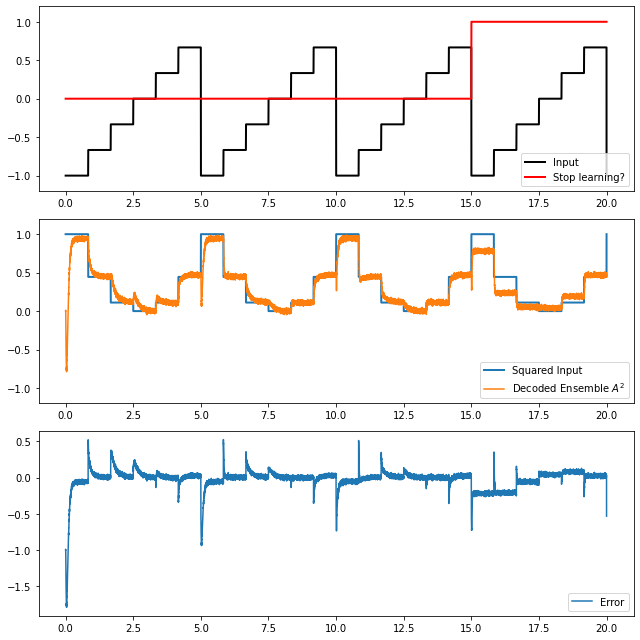

In [6]:
# Plot the input signal
plt.figure(figsize=(9, 9))
plt.subplot(3, 1, 1)
plt.plot(
    sim.trange(), sim.data[input_node_probe], label="Input", color="k", linewidth=2.0
)
plt.plot(
    sim.trange(),
    sim.data[learn_probe],
    label="Stop learning?",
    color="r",
    linewidth=2.0,
)
plt.legend(loc="lower right")
plt.ylim(-1.2, 1.2)

plt.subplot(3, 1, 2)
plt.plot(
    sim.trange(), sim.data[input_node_probe] ** 2, label="Squared Input", linewidth=2.0
)
plt.plot(sim.trange(), sim.data[A_squared_probe], label="Decoded Ensemble $A^2$")
plt.legend(loc="lower right")
plt.ylim(-1.2, 1.2)

plt.subplot(3, 1, 3)
plt.plot(
    sim.trange(),
    sim.data[A_squared_probe] - sim.data[input_node_probe] ** 2,
    label="Error",
)
plt.legend(loc="lower right")
plt.tight_layout()

We see that during the first three periods,
the decoders quickly adjust to drive the error to zero.
When learning is turned off for the fourth period,
the error stays closer to zero,
demonstrating that the learning has persisted in the connection.